In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from sklearn.svm import SVC
from src.data.handlers import DataLoader
from src.models.classification.train_models import ClassificationTraining
from src.utils.constants import TARGET_NAMES

2024-09-27 00:00:57.125185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 00:00:57.125559: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 00:00:57.128796: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 00:00:57.162747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 00:00:57.692375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
samples_per_composition = 30

dl = DataLoader()
datasets, _ = dl.load_cross_validation_datasets("classification", samples_per_composition)

ct = ClassificationTraining(samples_per_composition)
models = ct.load_training_models()

2024-09-27 00:01:01.869006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-27 00:01:01.869371: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def histogram_neurons_classes(model_id: int):
    k_folds = 10

    # Histogram bins config
    step = 0.05
    start, stop = 0, 1 + step
    bin_edges = np.arange(start, stop, step)

    # dim: folds, bins, classes, neurons
    hists = np.zeros((k_folds, 20, 3, 3), dtype=np.int16)

    for i, valid_data in enumerate(datasets["valid"]):
        model = models["outputs"][model_id]["folds"][i]["model"]
        inputs = tf.convert_to_tensor(valid_data["features"])

        if isinstance(model, SVC):
            logits = pd.DataFrame(model.predict_proba(inputs), columns=TARGET_NAMES)
        else:
            # using softmax function
            logits = pd.DataFrame(tf.nn.softmax(model(inputs)), columns=TARGET_NAMES)

        neurons_per_target = {}
        for j, target in enumerate(valid_data["targets"].columns):
            filtered = (valid_data["targets"][target] == 1.0).reset_index(drop=True)
            neurons_per_target = logits[filtered]
            for k in range(neurons_per_target.shape[1]):
                hist, _ = np.histogram(neurons_per_target.iloc[:, k], bins=bin_edges, density=False)
                hists[i, :, j, k] = hist

    H_mean = hists.mean(axis=0)
    H_std = hists.std(axis=0) / np.sqrt(k_folds - 1)

    f, axs = plt.subplots(3, 3, figsize=(6, 6), sharex=True, sharey=True)

    for i in range(H_mean.shape[1]):
        for j in range(H_mean.shape[2]):
            axs[j, i].stairs(H_mean[:, i, j], bin_edges, fill=False, lw=1)
            axs[j, i].errorbar(
                bin_edges[:-1] + step / 2, H_mean[:, i, j], yerr=H_std[:, i, j], fmt="none", ecolor="C1"
            )
            if i == 0:
                axs[j, i].set_ylabel(f"Neurônio \#{j+1}")
            if j == 0:
                axs[j, i].set_title(f"Classe: {TARGET_NAMES[i]}")
            axs[j, i].set_xlim([0, 1])
            axs[j, i].axvline(0.5, ls=":", c="black", alpha=0.5, zorder=0)

    model_name = models["outputs"][model_id]["model_name"].replace("#", "\#")
    f.suptitle(f"Modelo: {model_name}")
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    filename = model_name.replace("\#", "").replace(" ", "_").lower()
    f.savefig(os.path.join("notebooks", f"neurons_hist_{filename}.png"), dpi=600, bbox_inches="tight")
    plt.show()

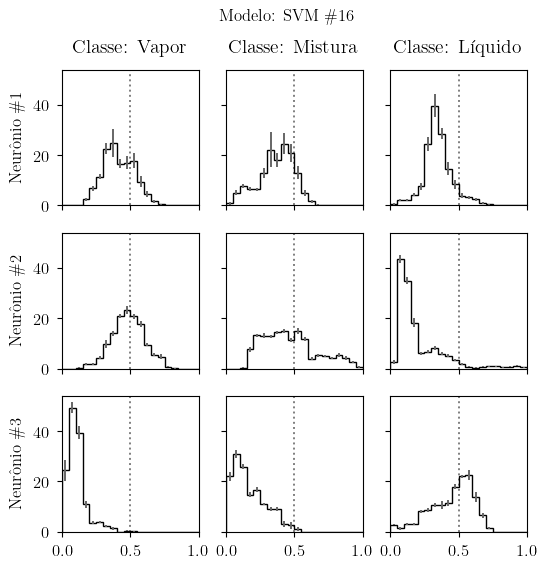

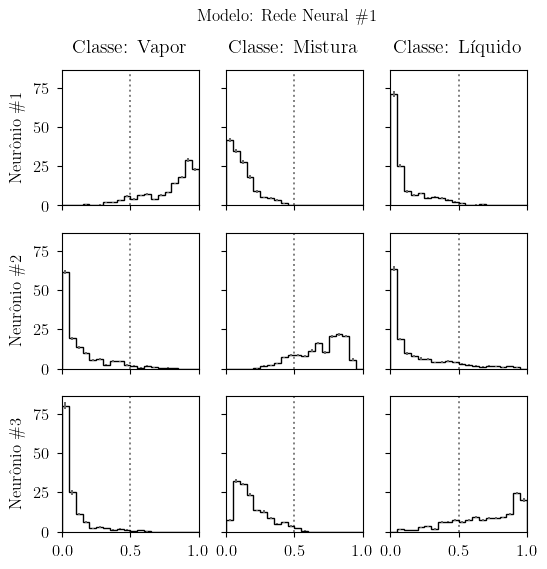

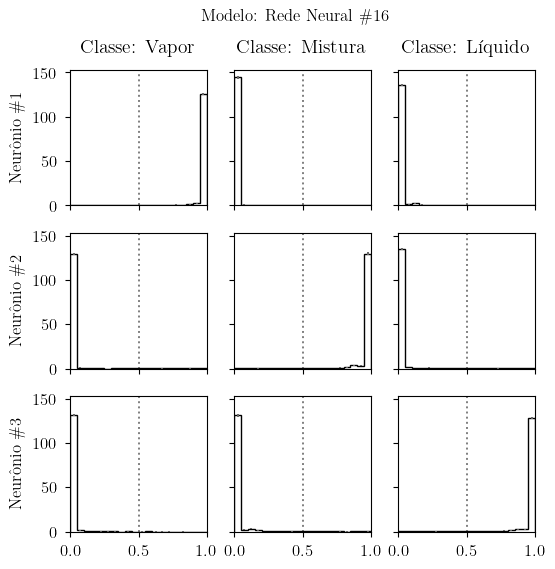

In [4]:
model_ids = [15, 18, -3]

for model_id in model_ids:
    histogram_neurons_classes(model_id)